<a href="https://colab.research.google.com/github/NahidurRahaman/Machine_Learning/blob/main/thesis(fer2013).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load FER2013 CSV
csv_path = '/content/drive/MyDrive/fer2013.csv'  # update path if needed
df = pd.read_csv(csv_path)

In [4]:
# Define emotion classes
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

import csv # Import the csv module

# Custom dataset from CSV
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pixels = list(map(int, self.df.iloc[idx]["pixels"].split()))
        img = np.asarray(pixels).reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img).convert("L")
        img = img.convert("RGB")  # convert to 3-channel RGB

        if self.transform:
            img = self.transform(img)

        label = int(self.df.iloc[idx]["emotion"])
        return img, label

In [5]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random zoom crop
    transforms.RandomHorizontalFlip(),                    # flip
    transforms.RandomRotation(15),                        # rotate
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)                # normalize
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
# Split manually
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

train_dataset = FER2013Dataset(train_df, transform=transform)
val_dataset = FER2013Dataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,num_workers=4, pin_memory=True)

Here is the code for the SRCNN model provided by the user. Note that this model is designed for super-resolution and takes a single-channel image as input and outputs a single-channel image.

In [7]:
import torch.nn as nn
import timm


In [8]:
class EfficientNetV2S_FeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetV2S_FeatureExtractor, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True, features_only=True)

    def forward(self, x):
        features = self.backbone(x)
        return features[-1]  # (B, 1280, 7, 7)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
efficientnet_model = EfficientNetV2S_FeatureExtractor().to(device)
efficientnet_model.eval()

# Use first batch from train_loader
for images, labels in train_loader:
    images = images.to(device)  # shape: (B, 3, 224, 224)
    labels = labels.to(device)

    with torch.no_grad():
        features = efficientnet_model(images)  # shape: (B, 1280, 7, 7)

    print("Input shape:", images.shape)
    print("EfficientNetV2-S Output shape:", features.shape)
    break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

Input shape: torch.Size([64, 3, 224, 224])
EfficientNetV2-S Output shape: torch.Size([64, 256, 7, 7])


In [10]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(ConvNeXtBlock, self).__init__()
        self.convnext = timm.create_model('convnext_tiny', pretrained=True, features_only=True)
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.proj(x)  # Reduce 256 → 256 (no change)
        return x  # shape: B × 256 × 7 × 7

In [11]:
class SE_MBConvBlock(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super(SE_MBConvBlock, self).__init__()
        self.expand = nn.Conv2d(in_channels, in_channels * 6, kernel_size=1)
        self.depthwise = nn.Conv2d(in_channels * 6, in_channels * 6, kernel_size=3, padding=1, groups=in_channels * 6)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * 6, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, in_channels * 6, 1),
            nn.Sigmoid()
        )
        self.project = nn.Conv2d(in_channels * 6, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.expand(x)
        x = self.depthwise(x)
        se_weight = self.se(x)
        x = x * se_weight
        x = self.project(x)
        return x  # shape: B × 256 × 7 × 7

In [12]:
adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))


In [13]:
class MultiBranchFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiBranchFeatureExtractor, self).__init__()
        self.efficientnet = EfficientNetV2S_FeatureExtractor()
        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()
        self.pool = nn.AdaptiveAvgPool2d((28, 28))  # Resize to 28×28

    def forward(self, x):
        x = self.efficientnet(x)  # Output: B × 1280 × 7 × 7

        convnext_feat = self.convnext_block(x)     # B × 256 × 7 × 7
        senet_feat    = self.se_mbconv_block(x)    # B × 256 × 7 × 7

        convnext_feat = self.pool(convnext_feat)   # B × 256 × 28 × 28
        senet_feat    = self.pool(senet_feat)      # B × 256 × 28 × 28

        return convnext_feat, senet_feat


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiBranchFeatureExtractor().to(device)
model.eval()

for images, labels in train_loader:
    images = images.to(device)

    with torch.no_grad():
        conv_feat, se_feat = model(images)

    print("ConvNeXt Output:", conv_feat.shape)  # [B, 256, 28, 28]
    print("SENet+MBConv Output:", se_feat.shape)  # [B, 256, 28, 28]
    break


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

ConvNeXt Output: torch.Size([64, 256, 28, 28])
SENet+MBConv Output: torch.Size([64, 256, 28, 28])


In [15]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=256, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, feat_q, feat_kv):
        # Input: B × 256 × 28 × 28
        B, C, H, W = feat_q.shape

        # Flatten to sequences: B × 784 × 256
        q = feat_q.view(B, C, -1).permute(0, 2, 1)   # Q: (B, 784, 256)
        kv = feat_kv.view(B, C, -1).permute(0, 2, 1) # K,V: (B, 784, 256)

        # Cross-attention
        attn_output, _ = self.attn(q, kv, kv)        # (B, 784, 256)
        attn_output = self.norm(attn_output + q)     # Residual + Norm

        # Reshape back to spatial map: (B, 256, 28, 28)
        fused = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return fused  # Output: B × 256 × 28 × 28

In [16]:
class FullFeatureFusionBlock(nn.Module):
    def __init__(self):
        super(FullFeatureFusionBlock, self).__init__()
        self.backbone = MultiBranchFeatureExtractor()        # Gives conv_feat, se_feat
        self.cross_attn = CrossAttentionFusion(embed_dim=256, num_heads=4)

    def forward(self, x):
        conv_feat, se_feat = self.backbone(x)               # B × 256 × 28 × 28

        fused_feat = self.cross_attn(conv_feat, se_feat)    # B × 256 × 28 × 28

        return fused_feat  # ready for concatenation with other branches if needed

In [17]:
model = FullFeatureFusionBlock().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fused_output = model(images)

    print("Fused Output Shape:", fused_output.shape)  # Expected: [B, 256, 28, 28]
    break

Fused Output Shape: torch.Size([64, 256, 28, 28])


In [18]:
class GlobalContextBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(GlobalContextBranch, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        x = self.global_pool(x)   # [B, 256, 1, 1] after global pool, originally [B, 256, 7, 7]
        x = self.fc(x)            # [B, 64, 28, 28]
        return x

In [19]:
class LocalDetailBranch(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(LocalDetailBranch, self).__init__()
        self.local_cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.local_cnn(x)  # [B, 64, 28, 28]

In [20]:
class MultiBranchFullFusion(nn.Module):
    def __init__(self):
        super(MultiBranchFullFusion, self).__init__()
        self.feature_extractor = EfficientNetV2S_FeatureExtractor()

        self.convnext_block = ConvNeXtBlock()
        self.se_mbconv_block = SE_MBConvBlock()

        self.pool = nn.AdaptiveAvgPool2d((28, 28))
        self.cross_attn = CrossAttentionFusion(embed_dim=256)

        self.global_context = GlobalContextBranch()
        self.local_detail = LocalDetailBranch()

        # Add pooling to ensure consistent spatial dimensions before concatenation
        self.global_pool_out = nn.AdaptiveAvgPool2d((28, 28))
        self.local_pool_out = nn.AdaptiveAvgPool2d((28, 28))


    def forward(self, x):
        feat = self.feature_extractor(x)                # [B, 256, 7, 7]

        # ConvNeXt & SENet+MBConv
        conv_feat = self.pool(self.convnext_block(feat))  # [B, 256, 28, 28]
        se_feat   = self.pool(self.se_mbconv_block(feat)) # [B, 256, 28, 28]

        # Cross-attention fused output
        fused_attn = self.cross_attn(conv_feat, se_feat)  # [B, 256, 28, 28]

        # Extra branches
        global_feat = self.global_context(feat)           # Expected: [B, 64, 28, 28]
        local_feat  = self.local_detail(feat)             # Expected: [B, 64, 28, 28]

        # Ensure spatial dimensions are 28x28 before concatenation
        global_feat_pooled = self.global_pool_out(global_feat)
        local_feat_pooled = self.local_pool_out(local_feat)


        # Concatenate all
        final_feat = torch.cat([conv_feat, se_feat, fused_attn, global_feat_pooled, local_feat_pooled], dim=1)  # [B, 896, 28, 28]
        return final_feat

In [21]:
model = MultiBranchFullFusion().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        fusion_output = model(images)
    print("Final Fused Feature Shape:", fusion_output.shape)  # [B, 896, 28, 28]
    break


Final Fused Feature Shape: torch.Size([64, 896, 28, 28])


In [22]:
class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim=128, patch_size=2, depth=2, heads=4):
        super(MobileViTBlock, self).__init__()
        self.patch_size = patch_size
        ph, pw = patch_size, patch_size

        self.local_rep = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.fold = nn.Fold(output_size=(28, 28), kernel_size=patch_size, stride=patch_size)

        self.conv_before_trans = nn.Conv2d(in_channels * ph * pw, transformer_dim, kernel_size=1)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=heads,
            batch_first=True,
            dim_feedforward=transformer_dim * 2,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.conv_after_trans = nn.Conv2d(transformer_dim, in_channels * ph * pw, kernel_size=1)


        self.project = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        identity = x # B × C × H × W

        x = self.local_rep(x) # B × C × H × W

        # Unfold, Conv, and flatten for Transformer
        x = self.unfold(x) # B × (C*ph*pw) × (H*W / (ph*pw))
        x = x.view(B, C, ph*pw, -1).permute(0, 3, 2, 1).contiguous().view(B, -1, C*ph*pw) # B × N × (C*ph*pw)
        x = self.conv_before_trans(x.permute(0, 2, 1).view(B, C*ph*pw, H//ph, W//pw)).view(B, self.conv_before_trans.out_channels, -1).permute(0, 2, 1) # B × N × transformer_dim


        # Transformer
        x = self.transformer(x) # B × N × transformer_dim

        # Project back and Fold
        x = self.conv_after_trans(x.permute(0, 2, 1).view(B, self.conv_after_trans.in_channels, H//ph, W//pw)) # B × (C*ph*pw) × H/ph × W/pw
        x = x.view(B, C*ph*pw, -1) # B × (C*ph*pw) × N
        x = self.fold(x) # B × C × H × W

        # Project and Residual Connection
        x = self.project(x) # B × C × H × W
        x = x + identity # Residual connection

        return x # B × in_channels × H × W

In [23]:
class FinalModelWithMobileViT(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x


In [24]:
class FinalModelWithMobileViT1(nn.Module):
    def __init__(self):
        super(FinalModelWithMobileViT1, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=(2,2), depth=2, heads=4)

    def forward(self, x):
        x = self.fusion(x)         # [B, 896, 28, 28]
        x = self.mobilevit(x)      # [B, 896, 28, 28]
        return x

In [25]:
class FinalModelWithGAP(nn.Module):
    def __init__(self):
        super(FinalModelWithGAP, self).__init__()
        self.fusion = MultiBranchFullFusion()
        self.mobilevit = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Avg Pool → [B, 896, 1, 1]

    def forward(self, x):
        x = self.fusion(x)            # [B, 896, 28, 28]
        x = self.mobilevit(x)         # [B, 896, 28, 28]
        x = self.gap(x)               # [B, 896, 1, 1]
        x = x.view(x.size(0), -1)     # Flatten → [B, 896]
        return x


In [26]:
model = FinalModelWithGAP().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)

    print("Final Feature Vector Shape:", features.shape)  # [B, 896]
    break

Final Feature Vector Shape: torch.Size([64, 896])


In [27]:
class EmotionClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5, num_classes=7, out_ch=448):
        super().__init__()
        self.fusion = MultiBranchFullFusion()
        fused_ch = out_ch * 2
        self.project = nn.Conv2d(fused_ch, 896, kernel_size=1)
        self.mobilevit1 = MobileViTBlock(in_channels=896, transformer_dim=128, patch_size=2, depth=2, heads=4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(896, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 7)
        )
    def forward(self, x):
        x = self.fusion(x)      # [B, 2*out_ch, H, W]
        x = self.project(x)     # [B, 896, H, W]
        x = self.mobilevit1(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [28]:
model = EmotionClassifier().to(device)
model.eval()

for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    print("Model Output Shape:", logits.shape)  # [B, 7]
    break


Model Output Shape: torch.Size([64, 7])


In [29]:
import torch.optim as optim
from tqdm import tqdm

# ============================================================
# Mixup Function
# ============================================================
def mixup_data(x, y, alpha=0.2):
    """Returns mixed inputs, pairs of targets, and lambda"""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ============================================================
# Early Stopping Class
# ============================================================
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, alpha=0.2):
    best_acc = 0.0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    early_stopper = EarlyStopping(patience=10, min_delta=0.001)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # ===== Apply Mixup =====
            mixed_x, y_a, y_b, lam = mixup_data(inputs, labels, alpha)
            optimizer.zero_grad()

            # Forward
            outputs = model(mixed_x)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)

            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            running_corrects += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects / total

        # ===== Validation =====
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_corrects += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / val_total

        scheduler.step(val_loss)  # step LR scheduler

        # ===== Logging =====
        print(f"Epoch [{epoch}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        # ===== Save Best Model =====
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Saved Best Model")


        # Append history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    print(f"Training complete. Best Val Acc: {best_acc*100:.2f}%")
    return history

In [31]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)

In [32]:
num_epochs = 50  # or as needed
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50,
    alpha=0.2  # Mixup strength
)



Epoch [1/50]: 100%|██████████| 449/449 [05:24<00:00,  1.38it/s]


Epoch [1/50] | Train Loss: 1.6978 | Train Acc: 31.38% | Val Loss: 1.2670 | Val Acc: 59.93%
✅ Saved Best Model


Epoch [2/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [2/50] | Train Loss: 1.4472 | Train Acc: 37.37% | Val Loss: 1.1945 | Val Acc: 63.97%
✅ Saved Best Model


Epoch [3/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [3/50] | Train Loss: 1.3086 | Train Acc: 39.95% | Val Loss: 1.1402 | Val Acc: 66.30%
✅ Saved Best Model


Epoch [4/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [4/50] | Train Loss: 1.2424 | Train Acc: 44.75% | Val Loss: 1.1020 | Val Acc: 68.88%
✅ Saved Best Model


Epoch [5/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [5/50] | Train Loss: 1.1983 | Train Acc: 45.77% | Val Loss: 1.0929 | Val Acc: 70.10%
✅ Saved Best Model


Epoch [6/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [6/50] | Train Loss: 1.1207 | Train Acc: 44.81% | Val Loss: 1.0979 | Val Acc: 70.60%
✅ Saved Best Model


Epoch [7/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [7/50] | Train Loss: 1.0879 | Train Acc: 50.04% | Val Loss: 1.0865 | Val Acc: 70.48%


Epoch [8/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [8/50] | Train Loss: 1.0301 | Train Acc: 47.97% | Val Loss: 1.0837 | Val Acc: 70.95%
✅ Saved Best Model


Epoch [9/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [9/50] | Train Loss: 0.9927 | Train Acc: 49.02% | Val Loss: 1.0843 | Val Acc: 70.97%
✅ Saved Best Model


Epoch [10/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [10/50] | Train Loss: 0.9578 | Train Acc: 51.80% | Val Loss: 1.0912 | Val Acc: 70.87%


Epoch [11/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [11/50] | Train Loss: 0.9396 | Train Acc: 52.47% | Val Loss: 1.0985 | Val Acc: 71.22%
✅ Saved Best Model


Epoch [12/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [12/50] | Train Loss: 0.8950 | Train Acc: 54.42% | Val Loss: 1.0893 | Val Acc: 71.26%
✅ Saved Best Model


Epoch [13/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [13/50] | Train Loss: 0.8842 | Train Acc: 56.83% | Val Loss: 1.0959 | Val Acc: 71.36%
✅ Saved Best Model


Epoch [14/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [14/50] | Train Loss: 0.8441 | Train Acc: 52.76% | Val Loss: 1.0901 | Val Acc: 72.47%
✅ Saved Best Model


Epoch [15/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [15/50] | Train Loss: 0.8274 | Train Acc: 53.18% | Val Loss: 1.0841 | Val Acc: 71.91%


Epoch [16/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [16/50] | Train Loss: 0.8023 | Train Acc: 54.74% | Val Loss: 1.0881 | Val Acc: 72.26%


Epoch [17/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [17/50] | Train Loss: 0.8005 | Train Acc: 53.89% | Val Loss: 1.0911 | Val Acc: 72.22%


Epoch [18/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [18/50] | Train Loss: 0.8125 | Train Acc: 58.40% | Val Loss: 1.0918 | Val Acc: 72.01%


Epoch [19/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [19/50] | Train Loss: 0.7465 | Train Acc: 57.68% | Val Loss: 1.1280 | Val Acc: 72.16%


Epoch [20/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [20/50] | Train Loss: 0.7868 | Train Acc: 57.34% | Val Loss: 1.0995 | Val Acc: 71.80%


Epoch [21/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [21/50] | Train Loss: 0.8085 | Train Acc: 55.60% | Val Loss: 1.0969 | Val Acc: 72.25%


Epoch [22/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [22/50] | Train Loss: 0.8030 | Train Acc: 56.94% | Val Loss: 1.1313 | Val Acc: 72.18%


Epoch [23/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [23/50] | Train Loss: 0.7800 | Train Acc: 55.73% | Val Loss: 1.0927 | Val Acc: 72.47%


Epoch [24/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [24/50] | Train Loss: 0.8082 | Train Acc: 56.95% | Val Loss: 1.0918 | Val Acc: 72.78%
✅ Saved Best Model


Epoch [25/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [25/50] | Train Loss: 0.7716 | Train Acc: 55.38% | Val Loss: 1.0964 | Val Acc: 72.30%


Epoch [26/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [26/50] | Train Loss: 0.7663 | Train Acc: 52.80% | Val Loss: 1.1051 | Val Acc: 72.85%
✅ Saved Best Model


Epoch [27/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [27/50] | Train Loss: 0.7714 | Train Acc: 59.87% | Val Loss: 1.1004 | Val Acc: 72.86%
✅ Saved Best Model


Epoch [28/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [28/50] | Train Loss: 0.7896 | Train Acc: 57.65% | Val Loss: 1.0991 | Val Acc: 72.81%


Epoch [29/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [29/50] | Train Loss: 0.7354 | Train Acc: 56.78% | Val Loss: 1.0989 | Val Acc: 72.92%
✅ Saved Best Model


Epoch [30/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [30/50] | Train Loss: 0.7590 | Train Acc: 54.82% | Val Loss: 1.1021 | Val Acc: 72.60%


Epoch [31/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [31/50] | Train Loss: 0.7787 | Train Acc: 57.52% | Val Loss: 1.0967 | Val Acc: 72.60%


Epoch [32/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [32/50] | Train Loss: 0.7995 | Train Acc: 56.53% | Val Loss: 1.0937 | Val Acc: 73.07%
✅ Saved Best Model


Epoch [33/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [33/50] | Train Loss: 0.7784 | Train Acc: 53.87% | Val Loss: 1.0964 | Val Acc: 72.65%


Epoch [34/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [34/50] | Train Loss: 0.7227 | Train Acc: 52.95% | Val Loss: 1.1658 | Val Acc: 73.03%


Epoch [35/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [35/50] | Train Loss: 0.7759 | Train Acc: 55.99% | Val Loss: 1.1356 | Val Acc: 73.01%


Epoch [36/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [36/50] | Train Loss: 0.7884 | Train Acc: 59.10% | Val Loss: 1.0946 | Val Acc: 72.81%


Epoch [37/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [37/50] | Train Loss: 0.7680 | Train Acc: 56.89% | Val Loss: 1.0997 | Val Acc: 73.11%
✅ Saved Best Model


Epoch [38/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [38/50] | Train Loss: 0.7590 | Train Acc: 58.28% | Val Loss: 1.1293 | Val Acc: 72.95%


Epoch [39/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [39/50] | Train Loss: 0.7483 | Train Acc: 58.83% | Val Loss: 1.1353 | Val Acc: 72.82%


Epoch [40/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [40/50] | Train Loss: 0.7472 | Train Acc: 56.51% | Val Loss: 1.0975 | Val Acc: 73.14%
✅ Saved Best Model


Epoch [41/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [41/50] | Train Loss: 0.7681 | Train Acc: 53.88% | Val Loss: 1.0951 | Val Acc: 72.86%


Epoch [42/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [42/50] | Train Loss: 0.7288 | Train Acc: 58.63% | Val Loss: 1.1078 | Val Acc: 72.85%


Epoch [43/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [43/50] | Train Loss: 0.7134 | Train Acc: 58.26% | Val Loss: 1.0985 | Val Acc: 72.96%


Epoch [44/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [44/50] | Train Loss: 0.7177 | Train Acc: 59.12% | Val Loss: 1.0982 | Val Acc: 73.00%


Epoch [45/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [45/50] | Train Loss: 0.7491 | Train Acc: 58.00% | Val Loss: 1.0970 | Val Acc: 72.79%


Epoch [46/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [46/50] | Train Loss: 0.7336 | Train Acc: 55.00% | Val Loss: 1.0972 | Val Acc: 73.07%


Epoch [47/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [47/50] | Train Loss: 0.7150 | Train Acc: 56.70% | Val Loss: 1.0951 | Val Acc: 72.92%


Epoch [48/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [48/50] | Train Loss: 0.7625 | Train Acc: 59.05% | Val Loss: 1.0947 | Val Acc: 72.90%


Epoch [49/50]: 100%|██████████| 449/449 [05:28<00:00,  1.37it/s]


Epoch [49/50] | Train Loss: 0.7520 | Train Acc: 54.82% | Val Loss: 1.1130 | Val Acc: 73.11%


Epoch [50/50]: 100%|██████████| 449/449 [05:27<00:00,  1.37it/s]


Epoch [50/50] | Train Loss: 0.7433 | Train Acc: 55.99% | Val Loss: 1.0941 | Val Acc: 72.85%
Training complete. Best Val Acc: 73.14%


In [33]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


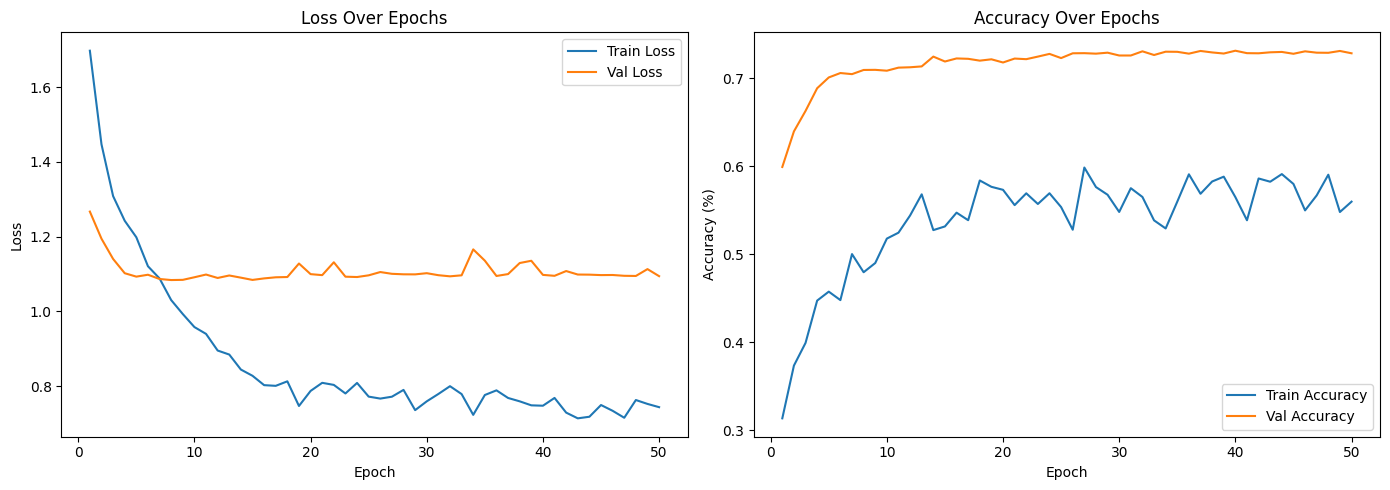

In [34]:
plot_training(history)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define all possible labels (0 to 6 for FER2013)
    all_possible_labels = list(range(len(class_names))) if class_names else sorted(list(set(all_labels + all_preds)))

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_possible_labels, zero_division=0)) # Added labels and zero_division

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=all_possible_labels) # Added labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.64      0.68      0.66       991
     Disgust       0.91      0.59      0.72       109
        Fear       0.67      0.54      0.60      1024
       Happy       0.87      0.91      0.89      1798
         Sad       0.64      0.63      0.63      1216
    Surprise       0.81      0.83      0.82       800
     Neutral       0.67      0.72      0.69      1240

    accuracy                           0.73      7178
   macro avg       0.74      0.70      0.72      7178
weighted avg       0.73      0.73      0.73      7178



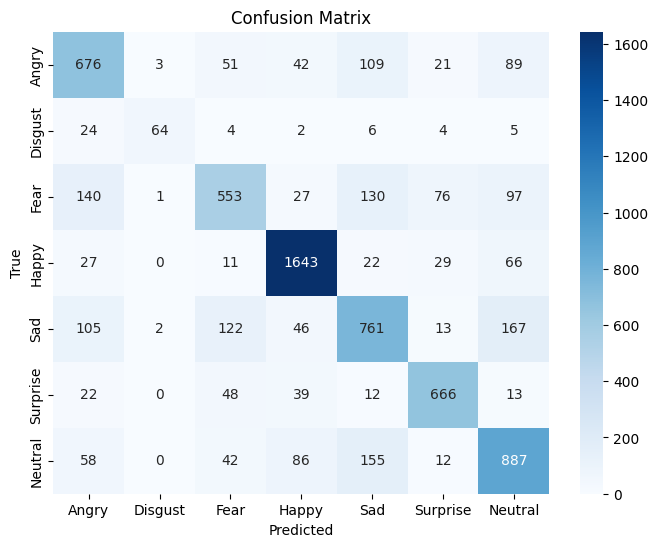

In [36]:
class_names = ['Angry', 'Disgust', 'Fear','Happy', 'Sad', 'Surprise', 'Neutral']
model.load_state_dict(torch.load("best_model.pth"))
evaluate_on_test(model, val_loader, device, class_names)
